# Explore the data in a GRDC day file

In [1]:
# set everything up
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option('display.width', 1000) # give print extra width to print more columns

### Read in station data from a folder containing the GRDC files, using the station identifier.

Specify the folder containing the GRDC daily datafiles and the station IDs of interest

In [2]:
my_grdc_folder = ".\GRDCdat_day"
# Use the line above if you started this notebook in a folder that contains the subfolder 'GRDCdat_day'
# my_grdc_folder = "D:\sbranchett\Jerom\GRDCdat_day"
my_stations = ["mytest", 6196700, 1445500, 5202150]

In [3]:
def dataframe_from_stationId(grdc_folder, station_id):
    ''' Search the grdc_folder for a file with name <station_id>.day,
    skip the header rows and return the dates and discharges in a dataframe'''
    
    filename = str(station_id) + ".day"
    grdc_file = os.path.join(grdc_folder, filename)

    grdc_data = pd.read_csv(grdc_file, skiprows=40, delimiter=';')
    grdc_data = grdc_data.rename(columns={'YYYY-MM-DD': 'date', ' Original': 'discharge'})
    grdc_data = grdc_data.reset_index().set_index(pd.DatetimeIndex(grdc_data['date']))
    grdc_data = grdc_data[['date', 'discharge']]
    
    return grdc_data

In [4]:
# collect the GRDC data for the specified stations
grdc_dataframes = {}
for station in my_stations:
    grdc_dataframes[station] = dataframe_from_stationId(my_grdc_folder, station)

### Missing data is set to -999, so these are easily visible as large negative values of discharge.

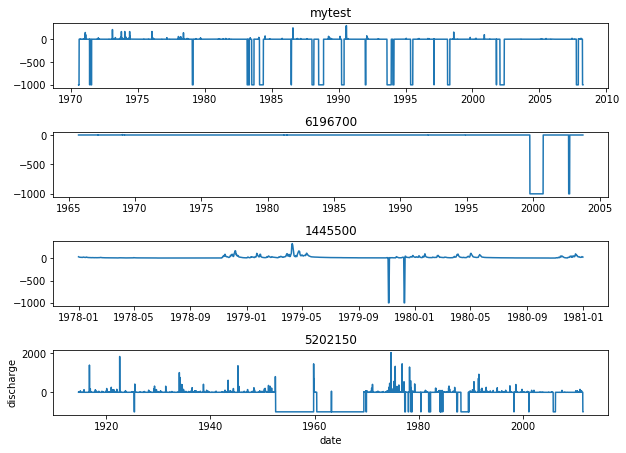

In [5]:
# plot the discharge values as a function of the date for the specified stations

no_plots = len(grdc_dataframes)
fig, axs = plt.subplots(no_plots, 1, figsize=(8.8, 1.6*no_plots))

if no_plots == 1:
    for idx, grdc_dataframe in grdc_dataframes.items(): # there is only one station to plot
        plt.plot(grdc_dataframe.drop(columns=['date']))
elif no_plots > 1:
    subplot_index = 0
    for idx, grdc_dataframe in grdc_dataframes.items():
        axs[subplot_index].plot(grdc_dataframe.drop(columns=['date']))
        axs[subplot_index].set_title(idx)
        subplot_index += 1

plt.xlabel('date')
plt.ylabel('discharge')
plt.tight_layout()

### Make a dataframe containing valid discharge values for all the stations of interest

In [6]:
init = True
for idx, grdc_dataframe in grdc_dataframes.items():
    if init: # for the first station, there is no other data to merge with
        combined = grdc_dataframe.drop(columns=['date']).rename(columns={'discharge': 'discharge_'+str(idx)})
        init = False
    else:
        combined = pd.merge(combined, grdc_dataframe.drop(columns=['date']), how='outer', on='date',
                            sort=True)
        combined = combined.rename(columns={'discharge': 'discharge_'+str(idx)})

combined = combined.replace(-999., np.nan) # redefine the -999 discharge values as missing data

# run these lines to test missing rows
combined = combined.drop(pd.Timestamp('1979-11-07'))

combined['1979-11-03':'1979-11-09']

In [7]:
cleaned = combined.dropna(axis=0, how='any')
# 'combined' now contains the data for all the specified stations, including NaNs where there is no valid data
# 'cleaned' has rows/days with valid discharge data for each specified station

### Make series with valid data and (nearly) consecutive dates

In [8]:
def valid_series(cleaned, num_invalid_days=0):
    ''' Search through a combined, cleaned and sorted dataframe and return a dataframe with start
    end dates of series with (nearly) consecutive days of valid discharge data.
    num_invalid_days is the number of consecutive days in a series that may contain invalid data.
    
    Every row in the initial dataframe has valid data points for all stations. '''

    series = pd.DataFrame(columns=['Start Date', 'End Date', 'Number of days in series'])

    init = True
    for index, row in cleaned.iterrows():
        date = datetime.strptime(str(index), "%Y-%m-%d %H:%M:%S")
        if init: # initialise the first time around
            start_date = date
            end_date = date
            init = False
        elif ((date - end_date).days <= num_invalid_days+1):
            # allowed number of days apart, extend set
            end_date = date
        else:  # end the current series
            series_length = (end_date - start_date).days
            if (series_length > 0):
                series = series.append({'Start Date': start_date,
                          'End Date': end_date,
                          'Number of days in series': series_length+1}, ignore_index=True)
            start_date = date
            end_date = start_date
            
    # end the final series
    series_length = (end_date - start_date).days
    if (series_length > 0): # 
        series = series.append({'Start Date': start_date, 'End Date': end_date,
                                'Number of days in series': series_length+1}, ignore_index=True)
    return series

How many days may have data problems?

Specify the number of consecutive days in a series that may have invalid data.

Each station is evulated separately.

Default is 0.

In [9]:
num_invalid_days = 4

In [10]:
series = valid_series(cleaned, num_invalid_days)
print(series)

  Start Date   End Date Number of days in series
0 1978-01-12 1978-06-18                      158
1 1978-07-06 1978-08-28                       54
2 1978-09-14 1979-01-27                      136
3 1979-02-20 1980-05-13                      449
4 1980-05-30 1980-12-31                      216


### Select the index of the series above that you wish to use

In [11]:
series_idx = 3

In [12]:
start_date = series.loc[series_idx, "Start Date"]
end_date = series.loc[series_idx, "End Date"]

series_combined = combined.loc[start_date:end_date] # contains data for all the specified stations,
# for the time series selected. Includes NaN where there is no valid data

### Check that the dataframe for the selected series has consecutive days, one day for each row

In [13]:
def fill_with_empty_rows(original, first_day, last_day):
    ''' take a dataframe with a sorted Timestamp index (one row per day)
    and add missing days '''
    frame = original.copy()
    for day in (first_day + pd.to_timedelta(n, unit='d') for n in range((last_day-first_day).days + 1)):
        if day not in frame.index:
            frame.loc[day] = pd.Series([np.nan])
            frame = frame.sort_index()
    return(frame)

In [14]:
# Check that days are consecutive by first trying to add missing days
series_combined = fill_with_empty_rows(series_combined, series_combined.index[0],
                                       series_combined.index[-1])

if ((series_combined.index[-1] - series_combined.index[0]).days + 1 != len(series_combined.index)):
    print('The number of rows is not the same as the number of days. \
    Check that the Dataframe has one row per day and that the rows are sorted on date')

### Inspect any problem rows

In [15]:
# There should be no problems if num_invalid_days is 0
problems = series_combined[pd.isna(series_combined).any(axis=1)]
print(problems)
print(len(problems))

            discharge_mytest  discharge_6196700  discharge_1445500  discharge_5202150
date                                                                                 
1979-11-05             0.456                0.0                NaN              1.404
1979-11-06             0.379                0.0                NaN              1.579
1979-12-09             0.194                0.0                NaN              0.761
1979-12-10             0.111                0.0                NaN              0.744
4


### Do you want to replace the problem data with values calculated by linear interpolation of closest valid data?

In [16]:
interpolate = True # if num_invalid_days is 0 and len(problems) is zero, interpolate = True will have no effect

In [17]:
def fill_nans(value_before, value_after, num_vals):
    ''' Make a list of values, num_vals long, that are a linear interpolation between
    value_before and value_after. '''
    vals = []
    delta = (value_after - value_before) / (num_vals + 1)
    for i in range (num_vals):
        vals.append(value_before + ((i + 1) * delta))
    return vals

def replace_nans(original):
    ''' Return a copy of a dataframe, with the NaNs replaced by linearly interpolated values.
    The values are interpolated for each column/station in turn. '''
    
    interpolated = original.copy()
    for column in original:
        # for each station in turn, look for the invalid discharge values
        init = True
        interp_zone = False
        for index, value in original[column].iteritems():
            if init:
                assert(not np.isnan(value))
                # the first row should be valid as should the last
                low_idx = index
                low_val = value
                init = False
            elif (interp_zone):
                # in a NaN zone,
                # looking for the next valid value so it is possible to interpolate
                if (np.isnan(value)):
                    pass # already in a NaN zone before we got here
                else:
                    high_idx = index
                    high_val = value
                    fill_values = (fill_nans(low_val, high_val, (high_idx - low_idx).days - 1))
                    interpolated.loc[(low_idx + pd.Timedelta(days=1)):
                                     (high_idx - pd.Timedelta(days=1)), column] = fill_values
                    low_idx = index
                    low_val = value
                    interp_zone = False
            else:
                # in a valid value zone, checking for NaNs
                if (np.isnan(value)):
                    interp_zone = True
                else:
                    low_idx = index
                    low_val = value
    return interpolated

In [18]:
if interpolate:
    interpolated = replace_nans(series_combined)

In [19]:
print(series_combined[start_date:end_date])
# print(series_combined['1979-11-03':'1979-11-09']) # run this line to test missing rows

            discharge_mytest  discharge_6196700  discharge_1445500  discharge_5202150
date                                                                                 
1979-02-20             0.027                0.0               36.0              1.325
1979-02-21             0.027                0.0               29.0              1.528
1979-02-22             0.027                0.0               24.0              1.550
1979-02-23             0.027                0.0               23.0              1.419
1979-02-24             0.027                0.0               34.0              1.298
1979-02-25             0.027                0.0               39.0              1.225
1979-02-26             0.027                0.0               30.0              1.158
1979-02-27             0.027                0.0               29.0              1.103
1979-02-28             0.027                0.0               26.0              1.103
1979-03-01             0.027                0.0       

In [20]:
if interpolate:
    print(interpolated[start_date:end_date])
    # print(interpolated['1979-11-03':'1979-11-09']) # run this line to test missing rows

            discharge_mytest  discharge_6196700  discharge_1445500  discharge_5202150
date                                                                                 
1979-02-20             0.027                0.0               36.0              1.325
1979-02-21             0.027                0.0               29.0              1.528
1979-02-22             0.027                0.0               24.0              1.550
1979-02-23             0.027                0.0               23.0              1.419
1979-02-24             0.027                0.0               34.0              1.298
1979-02-25             0.027                0.0               39.0              1.225
1979-02-26             0.027                0.0               30.0              1.158
1979-02-27             0.027                0.0               29.0              1.103
1979-02-28             0.027                0.0               26.0              1.103
1979-03-01             0.027                0.0       